Task 3: Teleportation

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
#from qiskit.ignis.verification import marginal_counts
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector
from qiskit import transpile

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Suppose we want to send the qubit state $\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$ to a friend. 

The following code has been taken from https://qiskit.org/textbook/ch-algorithms/teleportation.html and modified to solve our problem

#### Step 1
We define a function that creates an entangled pair of qubits.

The pair it creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

Let's say we keep $q_1$ and we give $q_2$ to our friend after they part ways.

#### Step 2 

We define a function that applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit we are trying to send to our friend). Then it applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) that we are trying to send to our friend is $q_0$:

In [3]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

#### Step 3

Next, we define a function that applies a measurement to both qubits that we own, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. Then we send these two bits to our friend.

In [4]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

#### Step 4

Our friend, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

We define a function to encode this instructions

In [5]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

From the Task 1 we recover after each iteration a vector of the form $ \begin{align}
         y= \begin{bmatrix}
          0\\
            \vec{x}  \\
                   \end{bmatrix}
  \end{align}$
  that then transforms itself to a imput vector of the form
$ \begin{align}
 \begin{bmatrix}
       \vec{b}    \\
           0 \\
                   \end{bmatrix}
  \end{align}$, in each case we have a 4 entry vector with 2 entryes equal to 0, which means we can reduce the problem back to a 2 components vector and apply the algortihm to perform the teleportation of a single qubit. In this notebook, we will initialize our qubit in the quantum state $\vert\psi\rangle=(1,0)$.
  

<IPython.core.display.Latex object>

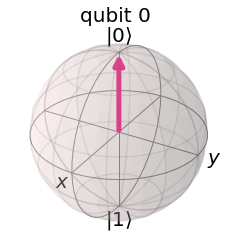

In [6]:
# Create random 1-qubit state
#psi = random_statevector(2)
#We consider only the entryies of vectort \vec{b}
psi  = np.array([1, 0])  #create our quantum state
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [7]:
init_gate = Initialize(psi)
init_gate.label = "init"


we can use the Aer simulator to verify our qubit has been teleported.

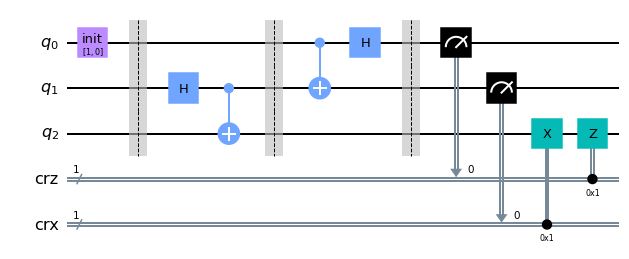

In [8]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

We can see below, using the statevector obtained from the aer simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

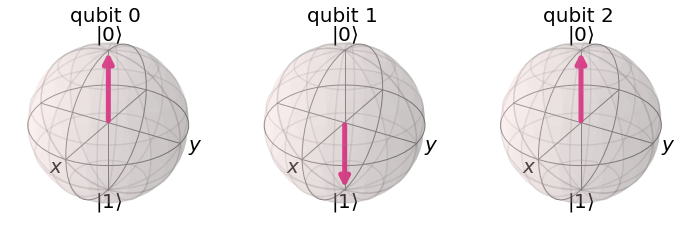

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
sim =Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)



### 3.3 Using the Simulated Counts <a id='simulating-fc'></a>

We can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we again use the aer simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. The `Initialize` instruction first performs a reset, setting our qubit to the state $|0\rangle$. It then applies gates to turn our $|0\rangle$ qubit into the state $|\psi\rangle$:

$$ |0\rangle \xrightarrow{\text{Initialize gates}} |\psi\rangle $$

Since all quantum gates are reversible, we can find the inverse of these gates using:

In [10]:
inverse_init_gate = init_gate.gates_to_uncompute()

This operation has the property:

$$ |\psi\rangle \xrightarrow{\text{Inverse Initialize gates}} |0\rangle $$

To prove the qubit $|q_0\rangle$ has been teleported to $|q_2\rangle$, if we do this inverse initialization on $|q_2\rangle$, we expect to measure $|0\rangle$ with certainty. We do this in the circuit below:

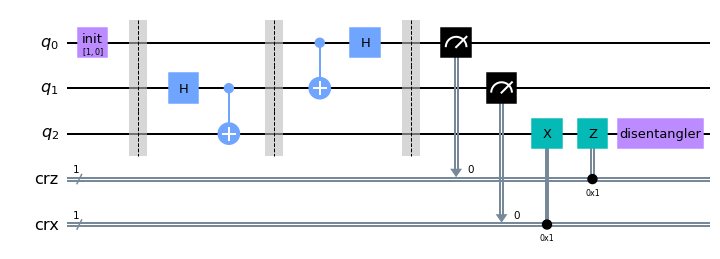

In [11]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

We can see the `inverse_init_gate` appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:

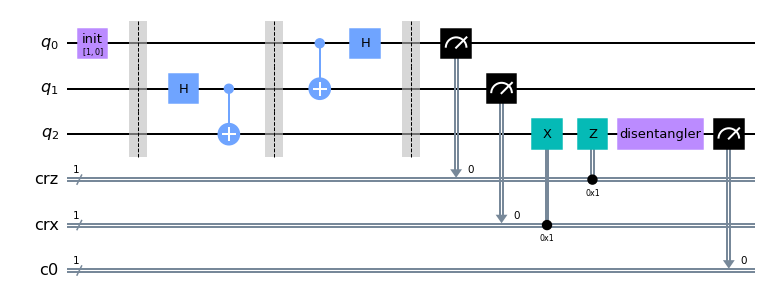

In [12]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

and we run our experiment:

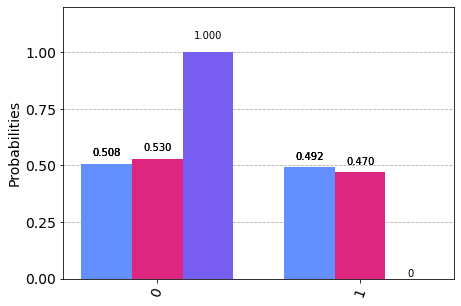

In [13]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

We can see we have a 100% chance of measuring $q_2$ (the purple bar in the histogram) in the state $|0\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

Teleportation algorithm + imput vector

<IPython.core.display.Latex object>

sign of our array: first entry = 1.0 second entry = -1.0


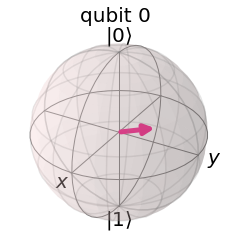

In [14]:
#
#We consider only the entries of vectort \vec{b} and take for example the following vector imput
psi = [np.sqrt(0.3),-np.sqrt(0.7)]   
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
sign1 = np.sign(psi[0]) #keep sign of the first entry of the array psi
sign2 = np.sign(psi[1])  #keep sign of the second entry of the array psi
print('sign of our array:', 'first entry =',sign1,'second entry =',sign2)
plot_bloch_multivector(psi)

            



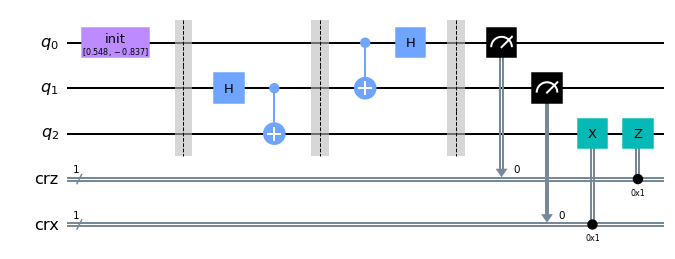

In [15]:
#instruction to create $|\psi\rangle$ from the state $|0\rangle$

init_gate = Initialize(psi)
init_gate.label = "init"
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)
qr2 =(1,"qrn")

## STEP 0
# First, let's initialize our's q0
qc.append(init_gate, [0])
qc.barrier()
st0 = Statevector.from_instruction(qc) 

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)



# Display the circuit
qc.draw()
            #


In [16]:

sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()

#Visualization of the Statevector.
out_vector.draw('latex')

<IPython.core.display.Latex object>

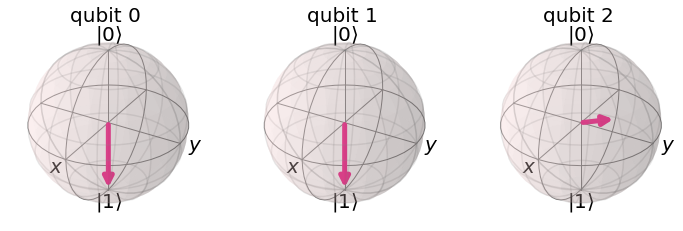

In [17]:
#Visualization on Bloch Spheres.
plot_bloch_multivector(out_vector)

In [18]:

#Obtain probabilities of Statevector
probs = out_vector.probabilities()
print( 'probabilities of our system of qubits: {}'.format(probs))
print()


# Probabilities for measuring only qubit-2
probs_qubit_0 = out_vector.probabilities([2])
print('Qubit-2 probabilities: {}'.format(probs_qubit_0))
print('probabilities qubit 2: zeroth component =' , probs_qubit_0[0],'first component =' , probs_qubit_0[1])
print()

#create a new teleported imput vector
vector2=np.array([sign1*np.sqrt(probs_qubit_0[0]),sign2*np.sqrt(probs_qubit_0[1])])
print('new imput teleported vector', vector2)
print()

# Display the output state vector
print(out_vector) 

#References for this part
#https://qiskit.org/documentation/stable/0.24/stubs/qiskit.quantum_info.Statevector.html

probabilities of our system of qubits: [0.  0.  0.  0.3 0.  0.  0.  0.7]

Qubit-2 probabilities: [0.3 0.7]
probabilities qubit 2: zeroth component = 0.2999999999999997 first component = 0.7000000000000001

new imput teleported vector [ 0.54772256 -0.83666003]

Statevector([-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.54772256+0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
              0.        -0.00000000e+00j, -0.83666003+1.02461302e-16j],
            dims=(2, 2, 2))


Here we present our code of quantum teleportation +  our code to simulate the orbit of the James Webb telescope

In [19]:
#Code to simulate the orbit of the James Webb telescope
xv1=[1] #initial position for quantum algorithm
yv1=[0]
cxv1 = [1] #initial position for classic algorithm
cyv1 = [0]
t1 = [] #list to keep track of time 
vector = np.array([1, 0, 0, 0])  #vector b representing initial position at time t=0
vector = vector/np.linalg.norm(vector)  #normaized vector b representing initial position at time t=0
for i in range(181):
    T = 180  #180 days= 6 months (30 days per month)
    dt = 1  #every day we measure
    #Quantum Teleportation
    #We consider only the first two entries of vectort \vec{b} as our imput state psi
    psi = [vector[0],vector[1]]   
    sign1 = np.sign(psi[0]) #keep sign of the first entry of the array psi
    sign2 = np.sign(psi[1])  #keep sign of the second entry of the array psi
    #instruction to create $|\psi\rangle$ from the state $|0\rangle$
    init_gate = Initialize(psi)
    init_gate.label = "init"
    qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
    crz = ClassicalRegister(1, name="crz") # and 2 classical registers
    crx = ClassicalRegister(1, name="crx")
    qc = QuantumCircuit(qr, crz, crx)
    qr2 =(1,"qrn")

    ## STEP 0
    # First, let's initialize Alice's q0
    qc.append(init_gate, [0])
    qc.barrier()
    st0 = Statevector.from_instruction(qc) 

    ## STEP 1
    # Now begins the teleportation protocol
    create_bell_pair(qc, 1, 2)
    qc.barrier()

    ## STEP 2
    # Send q1 to Alice and q2 to Bob
    alice_gates(qc, 0, 1)

    ## STEP 3
    # Alice then sends her classical bits to Bob
    measure_and_send(qc, 0, 1)

    ## STEP 4
    # Bob decodes qubits
    bob_gates(qc, 2, crz, crx)

    sim = Aer.get_backend('aer_simulator')
    qc.save_statevector()
    out_vector = sim.run(qc).result().get_statevector()

        
    #Obtain probabilities of Statevector
    probs = out_vector.probabilities()
    
    # Probabilities for measuring only qubit-2
    probs_qubit_0 = out_vector.probabilities([2])
    
    #create a new teleported imput vector adding the sign 
    vector2=np.array([sign1*np.sqrt(probs_qubit_0[0]),sign2*np.sqrt(probs_qubit_0[1]),0,0])
    
    
    
    #orbit of the James Webb 
    
    
    print('On day',i,'the results are') #print day of measurment
    print('new imput teleported vector', vector2)
    #print('normalized vector imput', vector)  #print normalized imput vector
    print('square of the norm of teleported vector imput',np.linalg.norm(vector2)**2) #print square of the norm of vector imput(sum of squared components) to cheek if it is a valid quantum state
    matrix = np.array([[0,0,1, (2*np.pi*dt)/T], [0,0,-(2*np.pi*dt)/T,1],[1,-(2*np.pi*dt)/T,0,0],[(2*np.pi*dt)/T,1,0,0] ])  #Hermitian Matrix
    naive_hhl_solution = HHL().solve(matrix, vector2)  #naive_hhl_solution from HHL algorithm
    classical_solution = NumPyLinearSolver().solve(matrix, vector2 / np.linalg.norm(vector2)) #classical_solution from classical solution algorithm
    naive_sv = Statevector(naive_hhl_solution.state).data #state vector of quantum solution
    #Extract the right vector components, i.e. those corresponding to the ancillary qubit (bottom in the circuits) being 1 and the work qubits (the four middle in the circuits) being 0, 
    #Extract the right vector components. |1000000> corresponds to the index 64, |1000001> corresponds to the index 65,|1000010> corresponds to the index 66 and |1000011> corresponds to the index 67
    naive_full_vector = np.array([ naive_sv[64], naive_sv[65], naive_sv[66], naive_sv[67]])
    naive_full_vector = np.real(naive_full_vector)  #Real part of naive_full_vector
    #We are interested in the third and fourth components of the solution vector, which correspond to the components of \vec{x} 
    #Thus, we are interested in the states |1000010> ,|1000011>, corresponding to the third and fourth components of the solution vector respectively. |1000010> corresponds to the index 66 and |1000011> corresponds to the index 67
    naive_partial_vector = np.array([ 0, 0, naive_sv[66], naive_sv[67]])
    naive_partial_vector = np.real(naive_partial_vector)  #Real part of naive_full_vector
    x=naive_partial_vector[2]/np.linalg.norm(naive_partial_vector)  #normalized x component
    y = naive_partial_vector[3]/np.linalg.norm(naive_partial_vector)  #normalized y component
    vector=np.array([x,y, 0, 0])  #normaized vector b representing initial position at time t=i*dt
    #print('full naive solution vector:', "y=[",0,"        ",0,"        ",naive_hhl_solution.euclidean_norm*naive_full_vector[2]/np.linalg.norm(naive_full_vector),naive_hhl_solution.euclidean_norm* naive_full_vector[3]/np.linalg.norm(naive_full_vector),"]")
    #we will divide the vectors by their respective norms to suppress any constants coming from the different parts of the circuits. The full solution vector can then be recovered by multiplying these normalised vectors by the respective Euclidean norms calculated above
    print('full naive solution vector:', "y=[",0,"        ",0,"        ",naive_hhl_solution.euclidean_norm*naive_partial_vector[2]/np.linalg.norm(naive_partial_vector),naive_hhl_solution.euclidean_norm* naive_partial_vector[3]/np.linalg.norm(naive_partial_vector),"]") #print full naive solution vector
    print('classical state:', "y=",classical_solution.state) #print classical state
    print()
    xv1.append(naive_hhl_solution.euclidean_norm*naive_partial_vector[2]/np.linalg.norm(naive_partial_vector))  #add the result from "x(t_i)" component obtained from HHL algorithm to the list
    yv1.append(naive_hhl_solution.euclidean_norm*naive_partial_vector[3]/np.linalg.norm(naive_partial_vector))  #add the result from "y(t_i)" component obtained from HHL algorithm to the list
    cxv1.append(classical_solution.state[2])  #add the result from "x(t_i)" component obtained from classical algorithm to the list
    cyv1.append(classical_solution.state[3])  #add the result from "y(t_i)" component obtained from classical algorithm to the list
    t1.append(i) #savind time step

On day 0 the results are
new imput teleported vector [1. 0. 0. 0.]
square of the norm of teleported vector imput 1.0
full naive solution vector: y=[ 0          0          0.9987830131823715 0.03486410418604186 ]
classical state: y= [0.         0.         0.99878301 0.0348641 ]

On day 1 the results are
new imput teleported vector [0.99939132 0.03488534 0.         0.        ]
square of the norm of teleported vector imput 0.9999999999999998
full naive solution vector: y=[ 0          0          0.9969588292189014 0.0696857663000798 ]
classical state: y= [0.         0.         0.99695883 0.06968577]

On day 2 the results are
new imput teleported vector [0.99756603 0.06972821 0.         0.        ]
square of the norm of teleported vector imput 0.9999999999999998
full naive solution vector: y=[ 0          0          0.9939209901395925 0.10442259593729666 ]
classical state: y= [0.         0.         0.99392099 0.1044226 ]

On day 3 the results are
new imput teleported vector [0.99452634 0.104

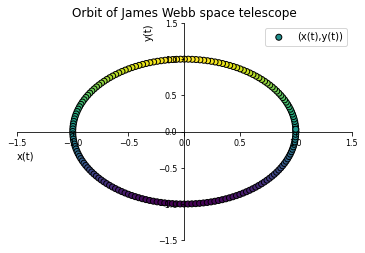

In [20]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.axis([-1.5,1.5,-1.5,1.5])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('y(t)', loc='top')
ax.set_xlabel('x(t)', loc='left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Orbit of James Webb space telescope')
#plt.grid()
plt.scatter(xv1, yv1,c=cyv1, ec='k', label='(x(t),y(t))')
ax.legend()
# changing the size of figure to 2X2


What the code does is it measures the position (x,y) of a  satellite and it prepares the valid quantum state, telleports it to earth and then it performs the linear differential equation solver for the period of T= 6 months. "Performing" another measurment we have other input state constructed from the position $(x_1,y_1)$ of another satellite.

As we have seen a quantum circuit can simulate the state that comes from the quantum state prepared by the satellite that scans one satellite orbiting earth and that efficiently encodes its positions. Then transmit its quantum measurements to a quantum computer on good old Earth and then perform the the linear differential equation solver. In order to do so, we have to consider valid quantum conditions early mencioned on Task 1. 

 We have plotted all the data for it's trayectory over the period of T=180 days= 6 months (30 days per month) performing a measurment every day. We found that the plotts of the $\vec{x}=(x(t),y(t))$ form a unitary circle, which we can consider as the trayectory of this telescope.
 
 For the quantum teleportation algorithm we had to consider only the components we were interested in, an extension of this work can be made by considering the full state preparation that the satellite makes every 24 hours and then sends it to earth. Other extension of this work comes from considering the full naive solution vector components (4 components) as a quantum imput following the results from Rigolin, G. (2005). Quantum teleportation of an arbitrary two-qubit state and its relation to multipartite entanglement. Physical Review A, 71(3), 032303. 
